# Reconciling 2SFCA and i2SFCA via distance decay parameterization


Abstract
Understanding spatial accessibility and facility crowdedness is central to public service planning, yet existing methods often treat these two metrics separately. The Two-Step Floating Catchment Area (2SFCA) method measures accessibility from the demand side, while the inverted 2SFCA (i2SFCA) assesses crowdedness from the supply side. However, without proper integration, these two measures may diverge, raising concerns of their validity. This study introduces a distance decay parameterization framework to reconcile 2SFCA and i2SFCA by optimizing a unified distance decay function through cross-entropy minimization. We demonstrate that aligning demand-side and supply-side flows effectively enforces a behavioral equilibrium between accessibility and crowdedness. A case study using inpatient hospital flow data in Florida shows that the reconciled 2SFCA (r2SFCA) model, especially when employing a Gaussian decay function, achieves strong alignment between estimated and observed service flows while maintaining methodological simplicity. These findings validate the self-organizing nature of human service-seeking behaviors and support a unified, entropy-based calibration strategy for accessibility modeling.


# 1 Read Data


## 1-1 Data
**r2SFCA_data.csv.gz**: A compressed CSV file containing the spatial accessibility input and output data used in the r2SFCA model analysis.



## 1-2 Data Dictionary
**SupplyID / DemandID:** Unique identifiers for supply locations (e.g., hospitals) and demand locations (e.g., residential areas) by ZCTA.

**Supply / Demand:** Quantitative values representing available health service capacity and population needs at each location.

**Travel_cost:** Impedance or distance matrix representing travel time or cost between demand and supply locations.

**O_Fij:** Observed patient flow from residential units to hospitals.

**O_Tij:** Realized allocation of health resources from hospitals to residential units, estimated based on accessibility modeling.

## 1-3 Read Data

In [1]:
import pandas as pd

url = "/content/r2SFCA_data.csv.gz"

data= pd.read_csv(url)

# 2 Function Definition

## 2-1 Distance Decay Function

In [42]:
import numpy as np
from enum import Enum

class DecayFunction(Enum):
    EXPONENTIAL = 'exponential'
    POWER = 'power'
    SIGMOID = 'sigmoid'
    SQRT_EXPONENTIAL = 'sqrt_exponential'
    GAUSSIAN = 'gaussian'
    LOG_SQUARED = 'log_squared'

def calculate_distance_decay(distance, beta, decay_type):

    epsilon = 1e-15
    decay_type = DecayFunction(decay_type) if isinstance(decay_type, str) else decay_type

    if decay_type == DecayFunction.EXPONENTIAL:
        # Exponential decay: exp(-beta * distance)
        return np.exp(-beta * distance)
    elif decay_type == DecayFunction.POWER:
        # Power function decay: distance^(-beta)
        return np.power(distance + epsilon, -beta)
    elif decay_type == DecayFunction.SIGMOID:
        # Sigmoid decay: 1 / (1 + exp(steepness * (distance - beta)))
        steepness = 3.0
        return 1.0 / (1 + np.exp(steepness * (distance - beta)))
    elif decay_type == DecayFunction.SQRT_EXPONENTIAL:
        # Square root exponential decay: exp(-beta * sqrt(distance))
        return np.exp(-beta * np.sqrt(distance + epsilon))
    elif decay_type == DecayFunction.GAUSSIAN:
        # Gaussian decay: exp(-beta * (distance/20)^2)
        return np.exp(-beta * np.power(distance / 20, 2))
    else:  # LOG_SQUARED
        # Log-squared decay: exp(-beta * log(distance)^2)
        return np.exp(-beta * np.power(np.log(distance + epsilon), 2))

## 2-2 Calculate Fij and Tij

In [3]:
import numpy as np
import pandas as pd

def calculate_fij(demand, supply, travel_cost, demand_ids, beta, decay_type):
    """
    Calculate the Fij values (demand-side accessibility) using 2SFCA method

    Args:
        demand: Demand values (numpy array)
        supply: Supply values (numpy array)
        travel_cost: Travel cost matrix (numpy array)
        demand_ids: Demand location IDs (numpy array)
        beta: Decay parameter (float)
        decay_type: Type of decay function (string or DecayFunction enum)

    Returns:
        Fij values (numpy array)
    """
    # Calculate supply-side decay coefficients
    sf_d = supply * calculate_distance_decay(travel_cost, beta, decay_type)

    # Get unique demand IDs and create a lookup dictionary
    unique_demand_ids = np.unique(demand_ids)

    # Initialize Fij result array
    fij = np.zeros_like(sf_d)

    # Calculate Fij for each demand location
    for d_id in unique_demand_ids:
        # Get indices where demand ID matches current ID
        d_mask = (demand_ids == d_id)

        # Get demand value for this ID
        d_value = demand[d_mask][0]

        # Calculate sum of supply * decay for this demand location
        sum_sf_d = np.sum(sf_d[d_mask])

        # Calculate Fij
        if sum_sf_d > 0:
            fij[d_mask] = d_value * sf_d[d_mask] / sum_sf_d

    return fij

def calculate_tij(demand, supply, travel_cost, supply_ids, beta, decay_type):
    """
    Calculate the Tij values (supply-side accessibility) using 2SFCA method

    Args:
        demand: Demand values (numpy array)
        supply: Supply values (numpy array)
        travel_cost: Travel cost matrix (numpy array)
        supply_ids: Supply location IDs (numpy array)
        beta: Decay parameter (float)
        decay_type: Type of decay function (string or DecayFunction enum)

    Returns:
        Tij values (numpy array)
    """
    # Calculate demand-side decay coefficients
    df_d = demand * calculate_distance_decay(travel_cost, beta, decay_type)

    # Get unique supply IDs
    unique_supply_ids = np.unique(supply_ids)

    # Initialize Tij result array
    tij = np.zeros_like(df_d)

    # Calculate Tij for each supply location
    for s_id in unique_supply_ids:
        # Get indices where supply ID matches current ID
        s_mask = (supply_ids == s_id)

        # Get supply value for this ID
        s_value = supply[s_mask][0]

        # Calculate sum of demand * decay for this supply location
        sum_df_d = np.sum(df_d[s_mask])

        # Calculate Tij
        if sum_df_d > 0:
            tij[s_mask] = s_value * df_d[s_mask] / sum_df_d

    return tij

## 2-3 Evaluation Metrics

In [46]:
import numpy as np
from scipy.stats import pearsonr

def evaluate_model(fij, tij, o_fij=None):
    """
    Evaluate model performance using cross-entropy and correlations

    Args:
        fij: Calculated Fij values (numpy array)
        tij: Calculated Tij values (numpy array)
        o_fij: Original/observed Fij values (numpy array, optional)

    Returns:
        Dictionary with evaluation metrics
    """
    epsilon = 1e-15

    # Normalize Fij and Tij for cross-entropy calculation
    fij_norm = fij / (np.sum(fij) + epsilon)
    tij_norm = tij / (np.sum(tij) + epsilon)

    # Calculate cross-entropy loss
    cross_entropy = -np.sum(fij_norm * np.log(tij_norm + epsilon))

    # Calculate correlation between Fij and Tij
    fij_tij_corr, _ = pearsonr(fij, tij)

    # Initialize flow correlation values
    fij_flow_corr = np.nan
    fij_flow_r2 = np.nan

    # Calculate correlation between Fij and original flows (if provided)

    fij_flow_corr, _ = pearsonr(fij, o_fij)

    return {
        'cross_entropy': cross_entropy,
        'fij_tij_correlation': fij_tij_corr,
        'fij_flow_correlation': fij_flow_corr,
    }

# 3 Grid Search

## 3-1 Sample scenario

In [5]:
# Parameters
beta = 3.2
decay_type = 'gaussian'

# Calculate with properly implemented functions (assuming they exist)
decay_values = calculate_distance_decay(data['TravelCost'].values, beta, decay_type)
fij = calculate_fij(data['Demand'].values, data['Supply'].values, data['TravelCost'].values, data['DemandID'].values, beta, decay_type)
tij = calculate_tij(data['Demand'].values, data['Supply'].values, data['TravelCost'].values, data['SupplyID'].values, beta, decay_type)
evaluation = evaluate_model(fij, tij, data['O_Fij'].values)

In [6]:
evaluation

{'cross_entropy': np.float64(8.4711169337753),
 'fij_tij_correlation': np.float64(0.790553107975219),
 'fij_flow_correlation': np.float64(0.8258051567042403)}

## 3-2 Grid Search

In [34]:
def grid_search(df,
                Demand='Demand',
                Supply='Supply',
                TravelCost='TravelCost',
                DemandID='DemandID',
                SupplyID='SupplyID',
                O_Fij='O_Fij',
                decay_type='exponential', num_steps=50, beta_start=0, beta_step=0.1):
    """
    Perform grid search over beta values for a specified decay function

    Args:
        df: DataFrame with columns DemandID, Demand, SupplyID, Supply, TravelCost, O_Fij, O_Tij
        decay_type: Type of decay function to use
        num_steps: Number of beta values to test
        beta_start: Starting beta value
        beta_step: Step size for beta values

    Returns:
        DataFrame with evaluation results for each beta value
    """
    # Extract data from DataFrame
    demand = df[Demand].values
    supply = df[Supply].values
    travel_cost = df[TravelCost].values
    demand_ids = df[DemandID].values
    supply_ids = df[SupplyID].values
    o_fij = df[O_Fij].values

    # Create beta values
    beta_values = np.array([beta_start + i * beta_step for i in range(num_steps)])

    # Initialize results storage
    results = []

    # Run grid search
    for beta in beta_values:
        # Calculate Fij and Tij
        fij = calculate_fij(demand, supply, travel_cost, demand_ids, beta, decay_type)
        tij = calculate_tij(demand, supply, travel_cost, supply_ids, beta, decay_type)

        # Evaluate model
        eval_metrics = evaluate_model(fij, tij, o_fij)

        # Store results
        result = {
            'beta': beta,
            'decay_type': decay_type,
            'cross_entropy': eval_metrics['cross_entropy'],
        }

        # Add flow correlation metrics if available

        result.update({
                'fij_flow_correlation': eval_metrics['fij_flow_correlation'],
            })

        results.append(result)

        # Print progress
        if (len(results) % (num_steps // 20 or 1)) == 0:
            print(f"Progress: {len(results)}/{num_steps} beta values tested")

    # Convert results to DataFrame
    results_df = pd.DataFrame(results)

    return results_df

In [13]:
def plot_grid_search_results(results_df):
    """
    Simple plot function for grid search results with correlation on left y-axis and entropy on right

    Args:
        results_df: DataFrame with columns beta, cross_entropy, fij_flow_correlation, decay_type
    """
    import matplotlib.pyplot as plt

    # Get decay type from the DataFrame
    decay_type = results_df['decay_type'].iloc[0]

    # Create figure with dual y-axes
    fig, ax1 = plt.subplots(figsize=(6, 6))

    # Primary y-axis: flow correlation (left)
    ax1.set_xlabel('Beta')
    ax1.set_ylabel('Fij-Flow Correlation', color='red')
    ax1.plot(results_df['beta'], results_df['fij_flow_correlation'], 'r-')
    ax1.tick_params(axis='y', labelcolor='red')
    ax1.set_ylim([0, 1])  # Set y-limits from 0 to 1

    # Find and plot maximum flow correlation
    max_corr_idx = results_df['fij_flow_correlation'].idxmax()
    max_corr_beta = results_df.loc[max_corr_idx, 'beta']
    ax1.axvline(x=max_corr_beta, color='red', linestyle=':')

    # Secondary y-axis: cross-entropy (right)
    ax2 = ax1.twinx()
    ax2.set_ylabel('Cross Entropy', color='blue')
    ax2.plot(results_df['beta'], results_df['cross_entropy'], 'b-')
    ax2.tick_params(axis='y', labelcolor='blue')

    # Find and plot minimum cross-entropy
    min_entropy_idx = results_df['cross_entropy'].idxmin()
    min_entropy_beta = results_df.loc[min_entropy_idx, 'beta']
    ax2.axvline(x=min_entropy_beta, color='blue', linestyle='--')

    # Title with decay type and beta range
    plt.title(f'{decay_type} Decay (β range: {results_df["beta"].min():.2f}-{results_df["beta"].max():.2f})')

    # No grid and no legend as requested
    plt.tight_layout()
    plt.savefig(f'grid_search_{decay_type}.png', dpi=300)
    plt.show()

In [28]:
def multi_plot_grid_search_results(results_dfs):
    """
    Plot function for grid search results in a 2x3 grid layout

    Args:
        results_dfs: List of DataFrames, each with columns beta, cross_entropy, fij_flow_correlation, decay_type
    """
    import matplotlib.pyplot as plt
    import numpy as np

    # Create a figure with 2x3 subplots
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()  # Flatten to make indexing easier

    # Plot each DataFrame in its own subplot
    for i, df in enumerate(results_dfs):
        if i >= 6:  # Ensure we don't exceed the 6 plots
            break

        # Get decay type from the DataFrame
        decay_type = df['decay_type'].iloc[0]

        # Normalize data using min-max scaling
        corr_norm = (df['fij_flow_correlation'] - df['fij_flow_correlation'].min()) / \
                   (df['fij_flow_correlation'].max() - df['fij_flow_correlation'].min())

        entropy_norm = (df['cross_entropy'] - df['cross_entropy'].min()) / \
                      (df['cross_entropy'].max() - df['cross_entropy'].min())

        # Plot on single axis
        ax = axes[i]
        ax.plot(df['beta'], corr_norm, 'r-')
        ax.plot(df['beta'], entropy_norm, 'b-')

        # Find and plot maximum correlation and minimum entropy
        max_corr_idx = df['fij_flow_correlation'].idxmax()
        max_corr_beta = df.loc[max_corr_idx, 'beta']
        ax.axvline(x=max_corr_beta, color='red', linestyle=':')

        min_entropy_idx = df['cross_entropy'].idxmin()
        min_entropy_beta = df.loc[min_entropy_idx, 'beta']
        ax.axvline(x=min_entropy_beta, color='blue', linestyle='--')

        # Set title to just the decay type
        ax.set_title(f'{decay_type}')

        # Remove axis labels
        ax.set_xlabel('')
        ax.set_ylabel('')

    # Adjust layout
    plt.tight_layout()
    plt.savefig('grid_search_comparison.png', dpi=300)
    plt.show()

In [31]:
def create_summary_table(results_dfs):
    """
    Create a summary table showing the optimal beta values and corresponding metrics

    Args:
        results_dfs: List of DataFrames, each with columns beta, cross_entropy, fij_flow_correlation, decay_type

    Returns:
        A DataFrame summarizing the optimal values for each decay type
    """
    import pandas as pd

    # Create empty lists to store the results
    decay_types = []
    optimal_betas = []
    min_entropies = []
    corresponding_correlations = []

    # Process each DataFrame
    for df in results_dfs:
        # Get the decay type
        decay_type = df['decay_type'].iloc[0]

        # Find the row with minimum cross-entropy
        min_entropy_idx = df['cross_entropy'].idxmin()

        # Extract the values from that row
        optimal_beta = df.loc[min_entropy_idx, 'beta']
        min_entropy = df.loc[min_entropy_idx, 'cross_entropy']
        correlation = df.loc[min_entropy_idx, 'fij_flow_correlation']

        # Append to our lists
        decay_types.append(decay_type)
        optimal_betas.append(optimal_beta)
        min_entropies.append(min_entropy)
        corresponding_correlations.append(correlation)

    # Create a DataFrame with the results
    summary_df = pd.DataFrame({
        'Distance decay function (f(dij))': decay_types,
        'Parameter (β)': optimal_betas,
        'Cross-entropy value of Fij & Tij': min_entropies,
        'Correlation coefficient of observed & estimated Fij': corresponding_correlations
    })

    return summary_df


## 3-3 Grid Search-All-Result


EXPONENTIAL = 'exponential'  0-2

POWER = 'power' 0-10

SQRT_EXPONENTIAL = 'sqrt_exponential' 0-6

GAUSSIAN = 'gaussian' 0-10

LOG_SQUARED = 'log_squared' 0-2

SIGMOID = 'sigmoid' 0-60

In [47]:
# Run grid search for gaussian decay with 20 steps
exp_df = grid_search(data, decay_type='exponential', num_steps=100, beta_start=0, beta_step=0.02)
pow_df = grid_search(data, decay_type='power', num_steps=100, beta_start=0, beta_step=0.1)
sqr_df = grid_search(data, decay_type='sqrt_exponential', num_steps=60, beta_start=0, beta_step=0.1)
gau_df = grid_search(data, decay_type='gaussian', num_steps=100, beta_start=0, beta_step=0.1)
log_df = grid_search(data, decay_type='log_squared', num_steps=100, beta_start=0, beta_step=0.02)
sig_df = grid_search(data, decay_type='sigmoid', num_steps=60, beta_start=0, beta_step=1)

Progress: 5/100 beta values tested
Progress: 10/100 beta values tested
Progress: 15/100 beta values tested
Progress: 20/100 beta values tested
Progress: 25/100 beta values tested
Progress: 30/100 beta values tested
Progress: 35/100 beta values tested
Progress: 40/100 beta values tested
Progress: 45/100 beta values tested
Progress: 50/100 beta values tested
Progress: 55/100 beta values tested
Progress: 60/100 beta values tested
Progress: 65/100 beta values tested
Progress: 70/100 beta values tested
Progress: 75/100 beta values tested
Progress: 80/100 beta values tested
Progress: 85/100 beta values tested
Progress: 90/100 beta values tested
Progress: 95/100 beta values tested
Progress: 100/100 beta values tested
Progress: 5/100 beta values tested
Progress: 10/100 beta values tested
Progress: 15/100 beta values tested
Progress: 20/100 beta values tested
Progress: 25/100 beta values tested
Progress: 30/100 beta values tested
Progress: 35/100 beta values tested
Progress: 40/100 beta values 

<ipython-input-42-949cd58ceb4d>:26: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1 + np.exp(steepness * (distance - beta)))


Progress: 3/60 beta values tested
Progress: 6/60 beta values tested
Progress: 9/60 beta values tested
Progress: 12/60 beta values tested
Progress: 15/60 beta values tested
Progress: 18/60 beta values tested
Progress: 21/60 beta values tested
Progress: 24/60 beta values tested
Progress: 27/60 beta values tested
Progress: 30/60 beta values tested
Progress: 33/60 beta values tested
Progress: 36/60 beta values tested
Progress: 39/60 beta values tested
Progress: 42/60 beta values tested
Progress: 45/60 beta values tested
Progress: 48/60 beta values tested
Progress: 51/60 beta values tested
Progress: 54/60 beta values tested
Progress: 57/60 beta values tested
Progress: 60/60 beta values tested


## 3-4 Final Result

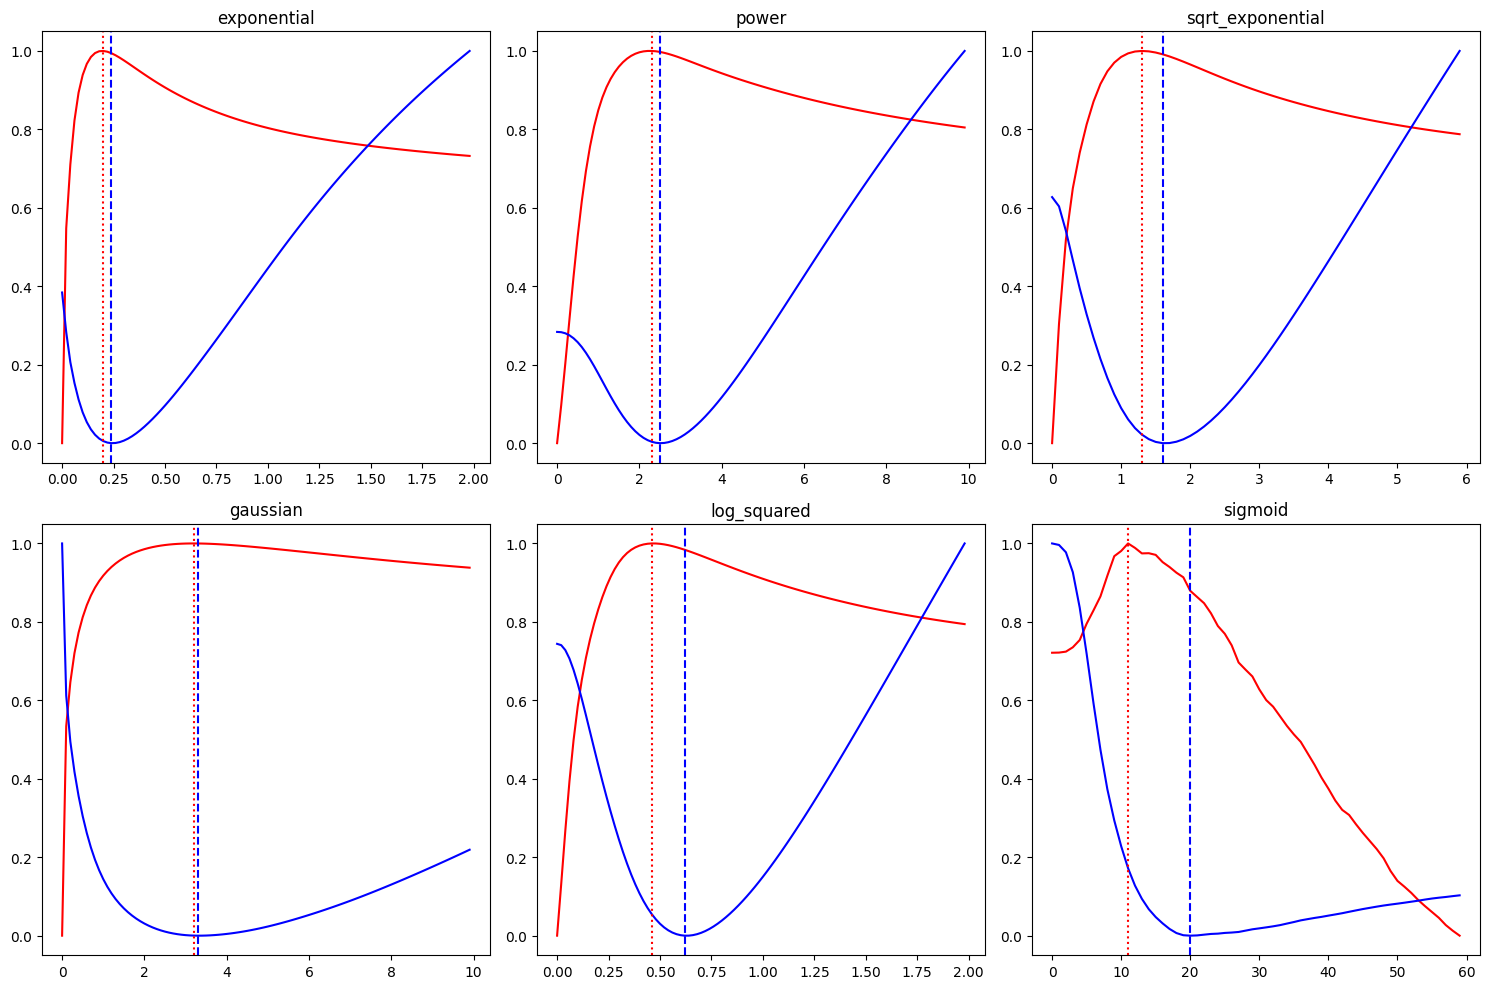

In [44]:
multi_plot_grid_search_results([exp_df,pow_df,sqr_df,gau_df,log_df ,sig_df] )

**Figure 3. Cross-entropy between estimated Fij and Tij [normalized to a scale 0-1, in blue] and correlation coefficient between estimated Fij and observed Fij [in red] across a range of distance decay parameter (β) in six functions**

In [45]:

# Example usage
summary_table = create_summary_table([exp_df,pow_df,sqr_df,gau_df,log_df ,sig_df] )
# Format the table with 3 decimal places
styled_table = summary_table.style.format({
    'Parameter (β)': '{:.2f}',
    'Cross-entropy value of Fij & Tij': '{:.3f}',
    'Correlation coefficient of observed & estimated Fij': '{:.3f}'
})
styled_table

,Distance decay function (f(dij)),Parameter (β),Cross-entropy value of Fij & Tij,Correlation coefficient of observed & estimated Fij
0,exponential,0.24,8.522,0.859
1,power,2.50,9.249,0.840
2,sqrt_exponential,1.60,8.693,0.867
3,gaussian,3.30,8.471,0.826
4,log_squared,0.62,8.696,0.863
5,sigmoid,20.00,8.617,0.686


# 4 Comparison between 2SFCA/CSA/3SFCA

## 4-1 CSA Model

In [48]:
def calculate_crowdedness(fij, supply_ids, supply):
    """
    Calculate crowdedness for each supply location

    Args:
        fij: Calculated Fij values (numpy array)
        supply_ids: Supply location IDs (numpy array)
        supply: Supply values (numpy array)

    Returns:
        Dictionary mapping supply IDs to crowdedness values
    """
    # Get unique supply IDs
    unique_supply_ids = np.unique(supply_ids)

    # Initialize crowdedness dictionary
    crowdedness = {}

    # Calculate crowdedness for each supply location
    for s_id in unique_supply_ids:
        # Get indices where supply ID matches current ID
        s_mask = (supply_ids == s_id)

        # Get supply value for this ID
        s_value = supply[s_mask][0]

        # Calculate sum of Fij for this supply location
        sum_fij = np.sum(fij[s_mask])

        # Calculate crowdedness
        if s_value > 0:
            crowdedness[s_id] = sum_fij / s_value
        else:
            crowdedness[s_id] = 0

    return crowdedness

In [49]:
def update_supply(supply, supply_ids, crowdedness, lamda):
    """
    Update supply values based on crowdedness

    Args:
        supply: Supply values (numpy array)
        supply_ids: Supply location IDs (numpy array)
        crowdedness: Dictionary mapping supply IDs to crowdedness values
        lamda: Crowdedness coefficient (float between 0 and 1)

    Returns:
        Updated supply values (numpy array)
    """
    # Initialize updated supply array
    updated_supply = np.zeros_like(supply)

    # Update supply for each location
    for i, s_id in enumerate(supply_ids):
        # Get crowdedness for this supply ID
        crowd = crowdedness.get(s_id, 0)

        # Ensure crowdedness is positive
        crowd = max(crowd, 1e-15)

        # Update supply based on crowdedness
        # Supply = Supply^(1+lamda)/(crowdedness^lamda)
        updated_supply[i] = np.power(supply[i], 1 + lamda) / np.power(crowd, lamda)

    return updated_supply

In [50]:
def reverseT2F(fij, crowdedness, supply_ids):
    """
    Calculate Tij from Fij and crowdedness

    Args:
        fij: Calculated Fij values (numpy array)
        crowdedness: Dictionary mapping supply IDs to crowdedness values
        supply_ids: Supply location IDs (numpy array)

    Returns:
        Tij values (numpy array)
    """
    # Initialize Tij result array
    tij = np.zeros_like(fij)

    # Calculate Tij for each location
    for i, s_id in enumerate(supply_ids):
        # Get crowdedness for this supply ID
        crowd = crowdedness.get(s_id, 0)

        # Ensure crowdedness is positive
        crowd = max(crowd, 1e-15)

        # Calculate Tij = Fij / crowdedness
        tij[i] = fij[i] / crowd

    return tij

In [55]:
def csa_grid_search(df,
                   Demand='Demand',
                   Supply='Supply',
                   TravelCost='TravelCost',
                   DemandID='DemandID',
                   SupplyID='SupplyID',
                   O_Fij='O_Fij',
                   decay_type='exponential',
                   num_steps=20,
                   beta_start=0,
                   beta_step=0.1,
                   lamda=0.5):
    """
    Perform grid search over beta values for CSA model with fixed lambda

    Args:
        df: DataFrame with columns DemandID, Demand, SupplyID, Supply, TravelCost, O_Fij
        decay_type: Type of decay function to use
        num_steps: Number of beta values to test
        beta_start: Starting beta value
        beta_step: Step size for beta values
        lamda: Fixed crowdedness coefficient value

    Returns:
        DataFrame with evaluation results for each beta value
    """
    # Extract data from DataFrame
    demand = df[Demand].values
    supply = df[Supply].values
    travel_cost = df[TravelCost].values
    demand_ids = df[DemandID].values
    supply_ids = df[SupplyID].values
    o_fij = df[O_Fij].values if O_Fij in df.columns else None

    # Create beta values
    beta_values = np.array([beta_start + i * beta_step for i in range(num_steps)])

    # Initialize results storage
    results = []

    # Total number of parameter combinations
    total_combinations = len(beta_values)
    current_combination = 0

    # Run grid search
    for beta in beta_values:
        # Calculate initial Fij
        initial_fij = calculate_fij(demand, supply, travel_cost, demand_ids, beta, decay_type)

        # Calculate crowdedness
        crowdedness = calculate_crowdedness(initial_fij, supply_ids, supply)

        # Update supply based on crowdedness
        updated_supply = update_supply(supply, supply_ids, crowdedness, lamda)

        # Recalculate Fij with updated supply
        fij = calculate_fij(demand, updated_supply, travel_cost, demand_ids, beta, decay_type)

        # Recalculate crowdedness
        crowdedness = calculate_crowdedness(fij, supply_ids, updated_supply)

        # Calculate Tij from Fij and crowdedness
        tij = reverseT2F(fij, crowdedness, supply_ids)

        # Evaluate model
        eval_metrics = evaluate_model(fij, tij, o_fij)

        # Store results
        result = {
            'beta': beta,
            'lamda': lamda,
            'decay_type': decay_type,
            'cross_entropy': eval_metrics['cross_entropy'],
            'fij_tij_correlation': eval_metrics['fij_tij_correlation'],
        }

        # Add flow correlation metrics if available
        if 'fij_flow_correlation' in eval_metrics:
            result['fij_flow_correlation'] = eval_metrics['fij_flow_correlation']

        results.append(result)

        # Update progress counter
        current_combination += 1

        # Print progress
        if current_combination % (total_combinations // 20 or 1) == 0:
            print(f"Progress: {current_combination}/{total_combinations} beta values tested")

    # Convert results to DataFrame
    results_df = pd.DataFrame(results)

    return results_df

In [56]:
CSA_02=csa_grid_search(data,decay_type='gaussian', num_steps=100,  beta_start=0,  beta_step=0.1,lamda=0.2)
CSA_04=csa_grid_search(data,decay_type='gaussian', num_steps=100,  beta_start=0,  beta_step=0.1,lamda=0.4)
CSA_06=csa_grid_search(data,decay_type='gaussian', num_steps=100,  beta_start=0,  beta_step=0.1,lamda=0.6)
CSA_08=csa_grid_search(data,decay_type='gaussian', num_steps=100,  beta_start=0,  beta_step=0.1,lamda=0.8)
CSA_10=csa_grid_search(data,decay_type='gaussian', num_steps=100,  beta_start=0,  beta_step=0.1,lamda=1.0)

Progress: 5/100 beta values tested
Progress: 10/100 beta values tested
Progress: 15/100 beta values tested
Progress: 20/100 beta values tested
Progress: 25/100 beta values tested
Progress: 30/100 beta values tested
Progress: 35/100 beta values tested
Progress: 40/100 beta values tested
Progress: 45/100 beta values tested
Progress: 50/100 beta values tested
Progress: 55/100 beta values tested
Progress: 60/100 beta values tested
Progress: 65/100 beta values tested
Progress: 70/100 beta values tested
Progress: 75/100 beta values tested
Progress: 80/100 beta values tested
Progress: 85/100 beta values tested
Progress: 90/100 beta values tested
Progress: 95/100 beta values tested
Progress: 100/100 beta values tested
Progress: 5/100 beta values tested
Progress: 10/100 beta values tested
Progress: 15/100 beta values tested
Progress: 20/100 beta values tested
Progress: 25/100 beta values tested
Progress: 30/100 beta values tested
Progress: 35/100 beta values tested
Progress: 40/100 beta values 

In [62]:
# Example usage
summary_CSA_table = create_summary_table([CSA_02,CSA_04,CSA_06,CSA_08,CSA_10 ] )
# Format the table with 3 decimal places
styled_CSA_table = summary_CSA_table.style.format({
    'Parameter (β)': '{:.2f}',
    'Cross-entropy value of Fij & Tij': '{:.3f}',
    'Correlation coefficient of observed & estimated Fij': '{:.3f}'
})
styled_CSA_table

,Distance decay function (f(dij)),Parameter (β),Cross-entropy value of Fij & Tij,Correlation coefficient of observed & estimated Fij
0,gaussian,9.00,7.657,0.798
1,gaussian,4.60,7.948,0.825
2,gaussian,3.00,8.092,0.808
3,gaussian,2.20,8.156,0.773
4,gaussian,1.80,8.176,0.738


## 4-2 3SFCA Model

In [63]:
class SFCAType(Enum):
    THREESFA = "3SFCA"    # Basic 3SFCA method
    ETHREESFA = "E3SFCA"  # Enhanced 3SFCA method

In [74]:
def calculate_selection_coefficient(decay, demand_ids, supply=None, sfca_type="3SFCA"):
    """
    Calculate selection coefficient G_ij

    Args:
        decay: Decay values (numpy array)
        demand_ids: Demand location IDs (numpy array)
        supply: Supply values (numpy array), only needed for E3SFCA
        sfca_type: SFCA method type (string: "3SFCA" or "E3SFCA")

    Returns:
        Selection coefficient G_ij (numpy array)
    """
    # Initialize selection coefficient array
    g_ij = np.zeros_like(decay)

    # Get unique demand IDs
    unique_demand_ids = np.unique(demand_ids)

    # Calculate selection coefficient for each demand location
    for d_id in unique_demand_ids:
        # Get indices for current demand location
        d_mask = (demand_ids == d_id)

        if sfca_type == "3SFCA":
            # 3SFCA: G_ij = f(d_ij) / Sum(f(d_ij))
            # Get all decay values for current demand location
            d_decays = decay[d_mask]

            # Calculate sum of decay values
            sum_decays = np.sum(d_decays)

            # Calculate selection coefficient
            if sum_decays > 0:
                g_ij[d_mask] = d_decays / sum_decays

        elif sfca_type == "E3SFCA":
            # E3SFCA: G_ij = Supply_j * f(d_ij) / Sum(Supply_j * f(d_ij))
            # Get all decay values and corresponding supply values for current demand location
            d_decays = decay[d_mask]
            d_supply = supply[d_mask]

            # Calculate supply-weighted decay values
            weighted_decays = d_supply * d_decays

            # Calculate sum of weighted decay values
            sum_weighted_decays = np.sum(weighted_decays)

            # Calculate selection coefficient
            if sum_weighted_decays > 0:
                g_ij[d_mask] = weighted_decays / sum_weighted_decays

    return g_ij

In [75]:
def calculate_3sfca_fij(demand, supply, travel_cost, demand_ids, beta, decay_type, sfca_type="3SFCA"):
    """
    Calculate Fij values (demand-side accessibility) using 3SFCA method

    Args:
        demand: Demand values (numpy array)
        supply: Supply values (numpy array)
        travel_cost: Travel cost matrix (numpy array)
        demand_ids: Demand location IDs (numpy array)
        beta: Decay parameter (float)
        decay_type: Type of decay function (string or DecayFunction enum)
        sfca_type: SFCA method type (string: "3SFCA" or "E3SFCA")

    Returns:
        Fij values (numpy array)
    """
    # Calculate distance decay
    decay = calculate_distance_decay(travel_cost, beta, decay_type)

    # Calculate selection coefficient G_ij
    g_ij = calculate_selection_coefficient(decay, demand_ids, supply, sfca_type)

    # Calculate supply-side decay coefficients
    sf_d = supply * decay

    # Get unique demand IDs
    unique_demand_ids = np.unique(demand_ids)

    # Initialize Fij result array
    fij = np.zeros_like(sf_d)

    # Calculate Fij for each demand location
    for d_id in unique_demand_ids:
        # Get indices for current demand location
        d_mask = (demand_ids == d_id)

        # Get demand value for current location
        d_value = demand[d_mask][0]

        # Get selection coefficients for current demand location
        d_gij = g_ij[d_mask]

        # Calculate sum of supply * decay for this demand location
        sum_sf_d = np.sum(sf_d[d_mask])

        # Calculate Fij: Demand * G_ij * S_j * f(d_ij) / Sum(S_j * f(d_ij))
        if sum_sf_d > 0:
            fij[d_mask] = d_value * d_gij * sf_d[d_mask] / sum_sf_d

    return fij

In [77]:
def TSFCA_grid_search(df,
                         Demand='Demand',
                         Supply='Supply',
                         TravelCost='TravelCost',
                         DemandID='DemandID',
                         SupplyID='SupplyID',
                         O_Fij='O_Fij',
                         decay_type='exponential',
                         num_steps=20,
                         beta_start=0,
                         beta_step=0.1,
                         sfca_type="3SFCA"):
    """
    Perform grid search over beta values for 3SFCA model

    Args:
        df: DataFrame with columns DemandID, Demand, SupplyID, Supply, TravelCost, O_Fij
        decay_type: Type of decay function to use
        num_steps: Number of beta values to test
        beta_start: Starting beta value
        beta_step: Step size for beta values
        sfca_type: SFCA method type (string: "3SFCA" or "E3SFCA")

    Returns:
        DataFrame with evaluation results for each beta value
    """
    # Extract data from DataFrame
    demand = df[Demand].values
    supply = df[Supply].values
    travel_cost = df[TravelCost].values
    demand_ids = df[DemandID].values
    supply_ids = df[SupplyID].values
    o_fij = df[O_Fij].values if O_Fij in df.columns else None

    # Create beta values
    beta_values = np.array([beta_start + i * beta_step for i in range(num_steps)])

    # Initialize results storage
    results = []

    # Total number of parameter combinations
    total_combinations = len(beta_values)
    current_combination = 0

    # Run grid search
    for beta in beta_values:
        # Calculate Fij using 3SFCA method
        fij = calculate_3sfca_fij(demand, supply, travel_cost, demand_ids, beta, decay_type, sfca_type)

        # Calculate crowdedness
        crowdedness = calculate_crowdedness(fij, supply_ids, supply)

        # Calculate Tij from Fij and crowdedness
        tij = reverseT2F(fij, crowdedness, supply_ids)

        # Evaluate model
        eval_metrics = evaluate_model(fij, tij, o_fij)

        # Store results
        result = {
            'beta': beta,
            'decay_type': decay_type,
            'sfca_type': sfca_type,
            'cross_entropy': eval_metrics['cross_entropy'],
            'fij_tij_correlation': eval_metrics['fij_tij_correlation'],
        }

        # Add flow correlation metrics if available
        if 'fij_flow_correlation' in eval_metrics:
            result['fij_flow_correlation'] = eval_metrics['fij_flow_correlation']

        results.append(result)

        # Update progress counter
        current_combination += 1

        # Print progress
        if current_combination % (total_combinations // 10 or 1) == 0:
            print(f"Progress: {current_combination}/{total_combinations} beta values tested")

    # Convert results to DataFrame
    results_df = pd.DataFrame(results)

    return results_df

In [78]:
N3SFCA_df= TSFCA_grid_search(data, decay_type='gaussian',num_steps=100,beta_start=0, beta_step=0.1,sfca_type="3SFCA")
E3SFCA_df= TSFCA_grid_search(data, decay_type='gaussian',num_steps=100,beta_start=0, beta_step=0.1,sfca_type="E3SFCA")

Progress: 10/100 beta values tested
Progress: 20/100 beta values tested
Progress: 30/100 beta values tested
Progress: 40/100 beta values tested
Progress: 50/100 beta values tested
Progress: 60/100 beta values tested
Progress: 70/100 beta values tested
Progress: 80/100 beta values tested
Progress: 90/100 beta values tested
Progress: 100/100 beta values tested
Progress: 10/100 beta values tested
Progress: 20/100 beta values tested
Progress: 30/100 beta values tested
Progress: 40/100 beta values tested
Progress: 50/100 beta values tested
Progress: 60/100 beta values tested
Progress: 70/100 beta values tested
Progress: 80/100 beta values tested
Progress: 90/100 beta values tested
Progress: 100/100 beta values tested


## 4-3 Plot

In [60]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_correlation_vs_beta(dfs, labels, x="beta", y="fij_flow_correlation",
                            title="Correlation vs Beta", figsize=(10, 6)):
    """
    Create a line plot for multiple dataframes showing how y changes with x.

    Parameters:
    -----------
    dfs : list of pandas DataFrames
        List of dataframes containing data to plot
    labels : list of str
        Labels for each dataframe (will be added as 'type' column)
    x : str, default="beta"
        Column name for x-axis
    y : str, default="fij_flow_correlation"
        Column name for y-axis
    title : str, default="Correlation vs Beta"
        Plot title
    figsize : tuple, default=(10, 6)
        Figure size

    Returns:
    --------
    fig, ax : matplotlib figure and axis objects
    """
    # Check if inputs are valid
    if len(dfs) != len(labels):
        raise ValueError("Number of dataframes must match number of labels")

    # Create a list to store modified dataframes
    modified_dfs = []

    # Add 'type' column to each dataframe
    for df, label in zip(dfs, labels):
        df_copy = df.copy()
        df_copy['type'] = label
        modified_dfs.append(df_copy)

    # Combine all dataframes
    combined_df = pd.concat(modified_dfs, ignore_index=True)

    # Create the plot
    plt.figure(figsize=figsize)

    # Use seaborn for better styling
    sns.set_style("whitegrid")

    # Create line plot  marker='o'
    ax = sns.lineplot(data=combined_df, x=x, y=y, hue='type')

    # Add labels and title
    plt.xlabel(x.capitalize())
    plt.ylabel(y.capitalize())
    plt.title(title)

    # Improve legend
    plt.legend(title="Type")

    # Adjust layout
    plt.tight_layout()

    return plt.gcf(), ax


## 4-4 Plot result of model comparison

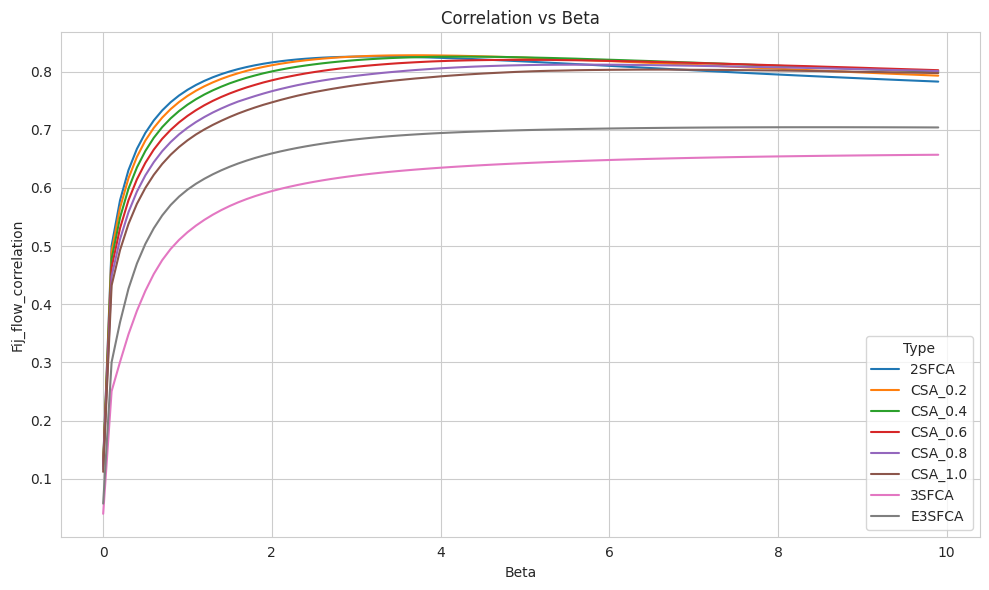

In [79]:

fig, ax = plot_correlation_vs_beta(
    dfs=[gau_df, CSA_02, CSA_04, CSA_06, CSA_08, CSA_10,N3SFCA_df,E3SFCA_df],
    labels=["2SFCA", "CSA_0.2", "CSA_0.4","CSA_0.6","CSA_0.8","CSA_1.0","3SFCA","E3SFCA"]
)
plt.show()

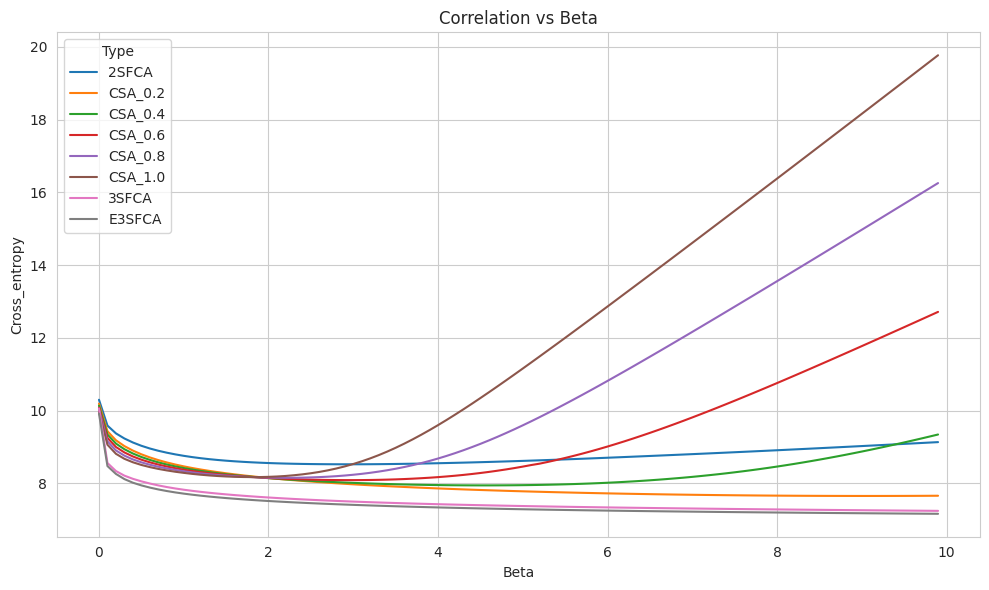

In [80]:
fig, ax = plot_correlation_vs_beta(
    dfs=[gau_df, CSA_02, CSA_04, CSA_06, CSA_08, CSA_10,N3SFCA_df,E3SFCA_df],
    labels=["2SFCA", "CSA_0.2", "CSA_0.4","CSA_0.6","CSA_0.8","CSA_1.0","3SFCA","E3SFCA"],
    y="cross_entropy"
)
plt.show()

**Table 1. Distance decay functions and optimal parameters**

# 5 Optimization with Adam

## 5-1 Adam function

In [ ]:
import numpy as np
import pandas as pd
from enum import Enum
from scipy.sparse import coo_matrix

class DecayFunction(Enum):
    EXPONENTIAL = 'exponential'
    POWER = 'power'
    BINARY = 'binary'

class SFCA2Model:
    def __init__(self, decay_type='exponential'):
        self.decay_type = DecayFunction(decay_type)
        self.log_beta = np.log(1)

    @property
    def beta(self):
        return np.exp(self.log_beta)

    def calculate_decay(self, distance, beta):
        if self.decay_type == DecayFunction.EXPONENTIAL:
            return np.exp(-beta * distance)
        elif self.decay_type == DecayFunction.POWER:
            return np.power(distance + 1e-10, -beta)
        else:  # BINARY
            steepness = 10.0
            return 1 / (1 + np.exp(-steepness * (beta - distance)))

    def build_group_matrix(self, ids, n_groups, n_total):
        unique_ids = np.unique(ids)
        id_to_idx = {id_: idx for idx, id_ in enumerate(unique_ids)}
        row_idx = np.array([id_to_idx[id_] for id_ in ids])
        col_idx = np.arange(n_total)

        values = np.ones(n_total)
        sparse_matrix = coo_matrix((values, (row_idx, col_idx)),
                                 shape=(n_groups, n_total))

        return sparse_matrix

    def calculate_Fij(self, demand, supply, travel_cost, demand_ids):
        sf_d = supply * self.calculate_decay(travel_cost, self.beta)

        unique_demand_ids = np.unique(demand_ids)
        n_demands = len(unique_demand_ids)
        n_total = len(demand_ids)

        group_matrix = self.build_group_matrix(demand_ids, n_demands, n_total)
        sum_sf_d = group_matrix.dot(sf_d)

        demand_values = np.zeros(n_demands)
        for i, d_id in enumerate(unique_demand_ids):
            mask = (demand_ids == d_id)
            demand_values[i] = demand[mask][0]

        group_matrix_t = group_matrix.T
        sum_sf_d_expanded = group_matrix_t.dot(sum_sf_d)
        demand_expanded = group_matrix_t.dot(demand_values)

        epsilon = 1e-10
        Fij = demand_expanded * sf_d / (sum_sf_d_expanded + epsilon)

        Fij = Fij / (np.sum(Fij) + epsilon)
        return Fij

    def calculate_Tij(self, demand, supply, travel_cost, supply_ids):
        df_d = demand * self.calculate_decay(travel_cost, self.beta)

        unique_supply_ids = np.unique(supply_ids)
        n_supplies = len(unique_supply_ids)
        n_total = len(supply_ids)

        group_matrix = self.build_group_matrix(supply_ids, n_supplies, n_total)
        sum_df_d = group_matrix.dot(df_d)

        supply_values = np.zeros(n_supplies)
        for i, s_id in enumerate(unique_supply_ids):
            mask = (supply_ids == s_id)
            supply_values[i] = supply[mask][0]

        group_matrix_t = group_matrix.T
        sum_df_d_expanded = group_matrix_t.dot(sum_df_d)
        supply_expanded = group_matrix_t.dot(supply_values)

        epsilon = 1e-10
        Tij = supply_expanded * df_d / (sum_df_d_expanded + epsilon)

        Tij = Tij / (np.sum(Tij) + epsilon)
        return Tij

    def compute_loss(self, demand, supply, travel_cost, demand_ids, supply_ids, actual_flows=None):
        Fij = self.calculate_Fij(demand, supply, travel_cost, demand_ids)
        Tij = self.calculate_Tij(demand, supply, travel_cost, supply_ids)

        epsilon = 1e-10
        cross_entropy = -np.sum(Fij * np.log(Tij + epsilon))

        if self.decay_type == DecayFunction.BINARY:
            regularization = 0.0001 * (self.log_beta ** 2)
        else:
            regularization = 0.001 * (self.log_beta ** 2)

        return cross_entropy + regularization, Fij, Tij

def optimize_parameters(data_df, decay_type='exponential', num_epochs=400, learning_rate=0.01):
    demand = data_df['Demand'].values.astype(np.float64)
    supply = data_df['Supply'].values.astype(np.float64)
    travel_cost = data_df['TravelCost'].values.astype(np.float64)
    actual_flows = data_df['O_Fij'].values.astype(np.float64)
    demand_ids = data_df['DemandID'].values.astype(np.int64)
    supply_ids = data_df['SupplyID'].values.astype(np.int64)

    model = SFCA2Model(decay_type)

    best_loss = float('inf')
    best_params = None
    best_fij = None
    best_tij = None
    report_data = []

    print(f"\nTraining with {decay_type} decay function")

    # Adam
    m_beta = 0
    v_beta = 0
    beta1 = 0.9
    beta2 = 0.999
    epsilon = 1e-8

    for epoch in range(num_epochs):
        try:
            loss, Fij, Tij = model.compute_loss(
                demand, supply, travel_cost, demand_ids, supply_ids
            )

            if np.isnan(loss):
                print(f"Warning: NaN loss detected at epoch {epoch+1}")
                continue

            # beta
            h = 1e-8
            model.log_beta += h
            loss_plus, _, _ = model.compute_loss(
                demand, supply, travel_cost, demand_ids, supply_ids
            )
            model.log_beta -= 2*h
            loss_minus, _, _ = model.compute_loss(
                demand, supply, travel_cost, demand_ids, supply_ids
            )
            model.log_beta += h
            grad_beta = (loss_plus - loss_minus) / (2*h)

            # update Adam
            t = epoch + 1
            m_beta = beta1 * m_beta + (1 - beta1) * grad_beta
            v_beta = beta2 * v_beta + (1 - beta2) * (grad_beta**2)
            m_hat_beta = m_beta / (1 - beta1**t)
            v_hat_beta = v_beta / (1 - beta2**t)

            # update parameter
            model.log_beta -= learning_rate * m_hat_beta / (np.sqrt(v_hat_beta) + epsilon)

            # best parameter
            if loss < best_loss:
                best_loss = loss
                best_params = {'beta': model.beta}
                best_fij = Fij.copy()
                best_tij = Tij.copy()

            # cor
            fij_corr = np.corrcoef(actual_flows, Fij)[0,1]
            tij_corr = np.corrcoef(actual_flows, Tij)[0,1]

            # iteration
            iteration_data = {
                'epoch': epoch + 1,
                'loss': loss,
                'beta': model.beta,
                'kl_divergence': loss,
                'fij_correlation': fij_corr,
                'tij_correlation': tij_corr
            }
            report_data.append(iteration_data)

            if (epoch + 1) % 10 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], '
                      f'Loss: {loss:.6f}, '
                      f'beta: {model.beta:.4f}, '
                      f'KL_div: {loss:.4f}, '
                      f'Fij_corr: {fij_corr:.4f}, '
                      f'Tij_corr: {tij_corr:.4f}')

        except Exception as e:
            print(f"Error at epoch {epoch+1}: {str(e)}")
            continue

    # DataFrame
    df_report = pd.DataFrame(report_data)

    # final cor
    final_fij_corr = np.corrcoef(actual_flows, best_fij)[0,1]
    final_tij_corr = np.corrcoef(actual_flows, best_tij)[0,1]

    print(f"\nBest parameters for {decay_type}:")
    print(f"beta: {best_params['beta']:.4f}")
    print(f"Final KL divergence: {best_loss:.4f}")
    print(f"Final Fij correlation: {final_fij_corr:.4f}")
    print(f"Final Tij correlation: {final_tij_corr:.4f}")

    return best_params['beta'], best_fij, best_tij, df_report

## 5-2 Adam with exponential

In [ ]:
beta, best_fij, best_tij, df_report=optimize_parameters(data, decay_type='exponential')


Training with exponential decay function
Epoch [10/400], Loss: 10.028924, beta: 0.9049, KL_div: 10.0289, Fij_corr: 0.7268, Tij_corr: 0.4681
Epoch [20/400], Loss: 9.792873, beta: 0.8197, KL_div: 9.7929, Fij_corr: 0.7381, Tij_corr: 0.4818
Epoch [30/400], Loss: 9.582608, beta: 0.7447, KL_div: 9.5826, Fij_corr: 0.7488, Tij_corr: 0.4966
Epoch [40/400], Loss: 9.404180, beta: 0.6796, KL_div: 9.4042, Fij_corr: 0.7593, Tij_corr: 0.5122
Epoch [50/400], Loss: 9.259573, beta: 0.6240, KL_div: 9.2596, Fij_corr: 0.7688, Tij_corr: 0.5280
Epoch [60/400], Loss: 9.125046, beta: 0.5750, KL_div: 9.1250, Fij_corr: 0.7781, Tij_corr: 0.5442
Epoch [70/400], Loss: 9.003638, beta: 0.5310, KL_div: 9.0036, Fij_corr: 0.7873, Tij_corr: 0.5609
Epoch [80/400], Loss: 8.901472, beta: 0.4924, KL_div: 8.9015, Fij_corr: 0.7960, Tij_corr: 0.5775
Epoch [90/400], Loss: 8.818848, beta: 0.4594, KL_div: 8.8188, Fij_corr: 0.8039, Tij_corr: 0.5935
Epoch [100/400], Loss: 8.752802, beta: 0.4310, KL_div: 8.7528, Fij_corr: 0.8109, Ti